## K-Nearest Neighbors Classifier - Malwai

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

# from src
from models import evaluation

ALGORITHM_NAME = 'knn'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

Using TensorFlow backend.


In [2]:
# Definition of Main Variables to Predict Poverty from the Household Survey

MWI_BASIC_FEATURES = [
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

In [3]:
# Standardise Data
def standardize(df, numeric_only=True):
    if numeric_only is True:
    # find non-boolean columns
        cols = df.loc[:,df.dtypes != 'uint8'].columns
    else:
        cols = df.columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field]-mean != 0):
            df.loc[:,field] = (df[field]-mean)/std
    
    return df

In [4]:
def drop_duplicate_columns(df, ignore=[], inplace=False):
    if not inplace:
        df = df.copy()

    # pairwise correlations
    corr = df.corr()
    corr[corr.columns] = np.triu(corr, k=1)
    corr = corr.stack()

    # for any perfectly correlated variables, drop one of them
    for ix, r in corr[(corr == 1)].to_frame().iterrows():
        first, second = ix

        if second in df.columns and second not in ignore:
            df.drop(second, inplace=True, axis=1)

    if not inplace:
        return df

In [5]:
# Split the data for analysis
def split_features_labels_weights(df,
                                  weights=['wta_pop', 'wta_hh'],
                                  weights_col=['wta_pop'],
                                  label_col=['poor']):

    '''Split data into features, labels, and weights dataframes'''
    data = df
    return (data.drop(weights + label_col, axis=1),
            data[label_col],
            data[weights_col])

In [6]:
# Load the processed Mwai household:
# mwi_hhold = pd.read_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_household.csv")
mwi_hhold = pd.read_csv("/home/mike/Documents/mkp_code/Institute of Data Course/Project 3/data/csv_data/MWI_2010_household.csv")

In [7]:
# Split Malawi data 
mwi_train, mwi_test = train_test_split(mwi_hhold, 
                                       test_size=0.25,
                                       random_state=1443,
                                       stratify=mwi_hhold.poor)

In [8]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(mwi_train)

In [9]:
# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 485 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,hid,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
7927,304044580160,5,3,0.0,1.0,3,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4210,205205820123,3,2,1.0,3.0,1,1,1,2,1,...,1,0,0,0,0,0,0,0,0,0
457,102016880095,6,5,0.0,2.0,3,1,2,2,0,...,0,0,0,0,0,0,0,0,0,0
11951,315356330210,3,3,3.0,3.0,1,1,1,3,1,...,1,1,0,0,0,0,0,0,1,1
11428,313061660067,2,1,0.0,2.0,0,1,1,2,0,...,1,0,0,1,0,0,0,0,0,0


In [10]:
# Select a few columns for this example
selected_columns = [
    'der_hhsize', 
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 10)


In [11]:
SUBSAMPLE = 0.1

def subsample(X, y, w, stratify=True, seed=566):
    n_samples = int(SUBSAMPLE * X.shape[0])
    
    rng = np.random.RandomState(seed)
    
    if stratify:
        y_rate = y.mean()
        n_true = int(n_samples * y_rate)
        n_false = n_samples - n_true
        
        true_idx = rng.choice(np.where(y)[0], n_true, replace=False)
        false_idx = rng.choice(np.where(~y)[0], n_false, replace=False)
        
        sample_idx = np.union1d(true_idx, false_idx)
    else:
        sample_idx = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    
    return X.iloc[sample_idx, :], y[sample_idx], w[sample_idx]

In [12]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


In [13]:
# Load and transform the training data
X_train, y_train, w_train = load_data(mwi_train, 
                                    selected_columns=selected_columns)       


In [14]:
# Create sub samples                                      
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

In [15]:
# Fit the model
model = KNeighborsClassifier()
%time model.fit(X_train, y_train)

CPU times: user 2.89 ms, sys: 0 ns, total: 2.89 ms
Wall time: 5.02 ms


KNeighborsClassifier()

In [16]:
# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

CPU times: user 30.2 ms, sys: 0 ns, total: 30.2 ms
Wall time: 58.3 ms
In-sample score: 80.07%


In [17]:
# Run the model
y_pred = model.predict(X_train)
y_prob = model.predict_proba(X_train)[:,1]

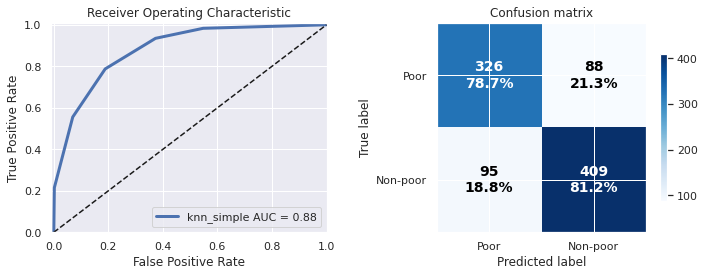

,knn_simple
accuracy,0.800654
recall,0.787440
precision,0.774347
f1,0.780838
cross_entropy,0.677274
roc_auc,0.881029
cohen_kappa,0.598045


In [18]:
# Evaluate performance of train model
metrics = evaluation.evaluate_model(y_train, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_train.columns.values)

In [19]:
# load testing data
X_test, y_test, w_test = split_features_labels_weights(mwi_test)

In [20]:
# Load and transform the training data
X_test, y_test, w_test = load_data(mwi_test, 
                                     selected_columns=selected_columns)       
# Create sub samples                                      
X_test, y_test, w_test = subsample(X_test, y_test, w_test)

In [21]:
# Fit the model
model = KNeighborsClassifier()
%time model.fit(X_test, y_test)


CPU times: user 3.05 ms, sys: 363 µs, total: 3.42 ms
Wall time: 4.77 ms


KNeighborsClassifier()

In [22]:
# Get an initial score
%time score = model.score(X_test, y_test)
print("In-sample score: {:0.2%}".format(score))

CPU times: user 8.3 ms, sys: 3.65 ms, total: 11.9 ms
Wall time: 22.4 ms
In-sample score: 75.82%


In [23]:
# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

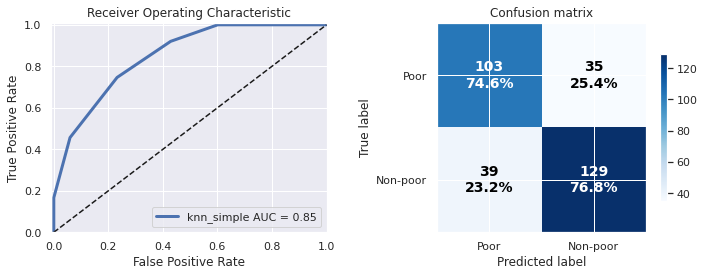

,knn_simple
accuracy,0.758170
recall,0.746377
precision,0.725352
f1,0.735714
cross_entropy,0.441336
roc_auc,0.850608
cohen_kappa,0.512907


In [24]:
# Evaluate performance of train model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)